In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
%matplotlib inline

### Explain why we used 2 csv files

The 2 data files were used to simulate all the parameters of the experiment. The first contains made up data that will be visualized live and regard the first cycles of the experiment. A complete image of the experiment is given in the second file, which is based on real data from BEXUS 24 and data given by our professor Dr Mpalis.

In [3]:
live_df = pd.read_excel('../Real-time analysis/XLSXs/First_Cycles.xlsx',
                        names=['time', 'P_in', 'P_out', 'T_in', 'T_out', 'Hum_in',
                               'Hum_out', 'CO2_V1', 'CO2_V2', 'O3_WE', 'O3_AE',
                               'Altitude','flags'],
                      header=0,
                      usecols=[i for i in range(0,13)])

In [4]:
live_df

,time,P_in,P_out,T_in,T_out,Hum_in,Hum_out,CO2_V1,CO2_V2,O3_WE,O3_AE,Altitude,flags
0,0,900.000000,963.209931,2.040243,2.040243,62,82,NaN,NaN,NaN,NaN,382,1
1,1,910.516068,962.286545,2.100652,2.000652,65,84,NaN,NaN,NaN,NaN,383,1
2,2,919.926260,962.323480,2.048742,1.798742,62,82,NaN,NaN,NaN,NaN,385,1
3,3,925.918178,961.104610,1.988110,1.763110,90,90,NaN,NaN,NaN,NaN,386,1
4,4,930.485607,961.584771,1.892872,1.592872,84,83,NaN,NaN,NaN,NaN,389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,996.785505,870.649688,4.900780,-1.974220,66,66,NaN,NaN,NaN,NaN,1174,1
216,216,997.608701,869.726301,2.182231,-2.017769,69,75,NaN,NaN,NaN,NaN,1178,1
217,217,998.294699,870.280333,2.249312,-2.025688,63,72,NaN,NaN,NaN,NaN,1182,1
218,218,997.907199,869.800172,3.750558,-2.049442,73,70,NaN,NaN,NaN,NaN,1185,1


In [5]:
button_df = pd.read_excel('../Real-time analysis/XLSXs/Sample CSV1.xlsx',
                       names=['time', 'P_in', 'P_out', 'T_in', 'T_out', 'Hum_in',
                              'Hum_out', 'CO2_V1', 'CO2_V2', 'O3_WE', 'O3_AE',
                              'Altitude','flags','flowrate','CO2','O3','CoM','SB_temp'],
                       header=0,
                       usecols=[i for i in range(0,18)])

In [6]:
button_df.head(50)

# CO2 %V/V
# O3 ppm or ppb

,time,P_in,P_out,T_in,T_out,Hum_in,Hum_out,CO2_V1,CO2_V2,O3_WE,O3_AE,Altitude,flags,flowrate,CO2,O3,CoM,SB_temp
0,35,NaN,947.586235,NaN,0.480382,NaN,78,NaN,NaN,NaN,NaN,502,NaN,NaN,0.033019,0.026461,NaN,NaN
1,166,NaN,889.449833,NaN,-1.265553,NaN,72,NaN,NaN,NaN,NaN,1001,NaN,NaN,0.033018,0.029416,NaN,NaN
2,308,NaN,835.819556,NaN,-3.870598,NaN,71,NaN,NaN,NaN,NaN,1502,NaN,NaN,0.033021,0.031615,NaN,NaN
3,451,NaN,783.408149,NaN,-6.800285,NaN,73,NaN,NaN,NaN,NaN,2002,NaN,NaN,0.033024,0.033814,NaN,NaN
4,591,NaN,734.764159,NaN,-9.634955,NaN,62,NaN,NaN,NaN,NaN,2500,NaN,NaN,0.033025,0.036357,NaN,NaN
5,726,NaN,688.373231,NaN,-13.071399,NaN,62,NaN,NaN,NaN,NaN,3000,NaN,NaN,0.033026,0.038900,NaN,NaN
6,861,NaN,644.272301,NaN,-16.832483,NaN,63,NaN,NaN,NaN,NaN,3502,NaN,NaN,0.033028,0.041861,NaN,NaN
7,994,NaN,602.424433,NaN,-20.328312,NaN,65,NaN,NaN,NaN,NaN,4003,NaN,NaN,0.033030,0.044821,NaN,NaN
8,1131,NaN,563.125112,NaN,-24.037929,NaN,43,NaN,NaN,NaN,NaN,4501,NaN,NaN,0.033032,0.049077,NaN,NaN
9,1265,NaN,525.118532,NaN,-27.897989,NaN,46,NaN,NaN,NaN,NaN,5000,NaN,NaN,0.033033,0.053333,NaN,NaN


### Functions for data handling

In [7]:
def O3Concentration(df):
    O3_WE = df.O3_WE
    O3_AE = df.O3_AE
    T_in = df.T_in  # σημαντικη για τις τιμες που θα χρησιμοποιηθουν στις σταθερες
    
    a = 1.64 # correction factor, εξαρταται απο θερμοκρασια μετρησης και σχετιζεται με τις επιφανειες των 2 μετρητων; 
    WEe = 37
    AEe = 25 # μετριουνται σε nanoAmpere , ενδεικτικες τιμες απο τον πινακα για θερμοκρασιες ~20
    b = 1 # η σταθερα που συνδεει συγκεντρωση και διορθωμενη μετρηση ρευματος, δεν ξερω ενδεικτικες τιμες, υπολογιζεται στο calibration
    WEc = O3_WE - WEe - a*(O3_AE - AEe)
    
    """Fitting & a=a(T_in)"""
    return b * WEc    

In [8]:
def CO2Concentration(df):
    CO2_V1 = df.CO2_V1
    CO2_V2 = df.CO2_V2
    T_in = df.T_in
    
    a= 1.52
    n= 0.724 # linearization coefficients υπολογιστουν στα tests (me fittings)
    Z = 1.33 
    S = 0.3604   # Zero και Span , θα υπολογιστούν οταν γίνουν τα test (me fittings)
    Tcal = 19.78 # kata protimhsh 20
    apos = 0.000556
    aneg = 0.000438
    bpos = 0.124
    bneg = 0.219
    
    """"TOWATCH Fitting Temp"""
    
    NR = CO2_V1/(Z*CO2_V2)
    
    if (T_in>Tcal):
        NRcomp = NR*(1+apos*(T_in-Tcal))
        Scomp = S + bpos*(T_in-Tcal)/Tcal
    else:
        NRcomp = NR*(1+aneg*(T_in-Tcal))
        Scomp = S + bneg*(T_in-Tcal)/Tcal
    
    if (1 - NRcomp > 0):
        result = ((-1/a)*np.log(1-(1-NRcomp)/Scomp)) **(1/n)
    else:
        result = -((-1/a)*np.log(1-(1-NRcomp)*(-1/Scomp))) **(1/n)
    return result

In [9]:
V_in = 2

def flowrate(df):
    flow_rate=[]
    j=0
    
    for k in df['time']:
        try:
            dt = df.loc[j+1, 'time'] - k
            
            dpin=df.loc[j+1, 'P_in'] - df.loc[j, 'P_in']
            
            #dtin=df.loc[j+1, 'T_in'] - df.loc[j, 'T_in']
            
            dtin=0
            pout=(df.loc[j+1, 'P_out'] + df.loc[j, 'P_out'])/2
            pin=(df.loc[j+1, 'P_in'] + df.loc[j, 'P_in'])/2
            
            tout=273+(df.loc[j+1, 'T_out'] + df.loc[j, 'T_out'])/2
            tin=273+(df.loc[j+1, 'T_in'] + df.loc[j, 'T_in'])/2
            
            flow=(V_in/pout)*(tout/tin)*(dpin/dt-(pin/tin)*dtin/dt)*60
            
            flow_rate.append(flow if flow>0 else None)
            
            j+=1
        except:
            continue
        
    return pd.Series(flow_rate, dtype='float64')

### Adding extra columns in dataframes

In [10]:
live_df['Flowrate'] = flowrate(live_df.mask(lambda x: x['flags']!=1))

live_df

,time,P_in,P_out,T_in,T_out,Hum_in,Hum_out,CO2_V1,CO2_V2,O3_WE,O3_AE,Altitude,flags,Flowrate
0,0,900.000000,963.209931,2.040243,2.040243,62,82,NaN,NaN,NaN,NaN,382,1,1.310518
1,1,910.516068,962.286545,2.100652,2.000652,65,84,NaN,NaN,NaN,NaN,383,1,1.172710
2,2,919.926260,962.323480,2.048742,1.798742,62,82,NaN,NaN,NaN,NaN,385,1,0.747009
3,3,925.918178,961.104610,1.988110,1.763110,90,90,NaN,NaN,NaN,NaN,386,1,0.569586
4,4,930.485607,961.584771,1.892872,1.592872,84,83,NaN,NaN,NaN,NaN,389,1,1.104256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,996.785505,870.649688,4.900780,-1.974220,66,66,NaN,NaN,NaN,NaN,1174,1,0.111247
216,216,997.608701,869.726301,2.182231,-2.017769,69,75,NaN,NaN,NaN,NaN,1178,1,0.093163
217,217,998.294699,870.280333,2.249312,-2.025688,63,72,NaN,NaN,NaN,NaN,1182,1,NaN
218,218,997.907199,869.800172,3.750558,-2.049442,73,70,NaN,NaN,NaN,NaN,1185,1,0.018180


## Plot handlers

In [11]:
def flow_rate_plot(df):
    plt.style.use('seaborn')
    
    flow_rate_figure, ax1 = plt.subplots()
    
    
    ax1.scatter(df['time'], df['Flowrate'], s=20, 
                marker= '.', label = "ECO-WISE 2021")
    
    ax1.set_title("Pump's flowrate")
    ax1.set_xlabel("Time (sec)")
    ax1.set_ylabel("Flowrate (L/min)")
    ax1.legend()
    plt.tight_layout()
    
    return flow_rate_figure

In [12]:
def temp_press_out_plot(df):
    
    temp_press_out_figure, ax3 = plt.subplots()
    
    plt.style.use('seaborn')
    
    colors=df['T_out']
    
    plot = ax3.scatter(df['P_out'], df['Altitude'], s=20, c=colors, cmap='jet', 
                  label = "ECO-WISE 2021",marker= '.')
    temp_press_out_figure.colorbar(plot, ax=ax3,label = 'Temperature out (°C)')
    
    
    ax3.set_title("Environmental variables")
    ax3.set_xlabel("Pressure (mbar)")
    ax3.set_ylabel("Altitude (m)")
    ax3.legend()
    plt.tight_layout()
    
    #ERRORS
    
    p = 1/100 #ποσοστό σφάλματος στην πίεση
    
    y_errormin = p*df['P_out']
    y_errormax = p*df['P_out']
    y_error = [y_errormin,y_errormax]
    
    x_error= 0
    
    ax3.errorbar(df['P_out'], 
                 df['Altitude'], 
                 yerr = y_error,
                 xerr = x_error, 
                 fmt=' ',
                 elinewidth=1,
                 capsize=5,
                 errorevery=100, 
                 capthick=1)  #ERROR EVERY για να φαίνεται στο γράφημα


    return temp_press_out_figure

In [13]:
def humidity_plot(df):
    humidity_figure, (hum_in,hum_out) = plt.subplots(nrows=2, ncols=1, sharex=True)
    
    #hum_in.grid(linewidth= 0.5, linestyle= '--', color= '#262626', alpha= 0.2)
    #hum_out.grid(linewidth= 0.5, linestyle= '--', color= '#262626', alpha= 0.2)
    #plt.rcParams['axes.facecolor'] = '#ccccff'
    plt.style.use('seaborn')
    
    hum_in.plot(df['time'], df['Hum_in'], label = "Hum in (ECO-WISE 2021)")
    hum_out.plot(df['time'], df['Hum_out'], label = "Hum out (ECO-WISE 2021)")
    
    hum_in.set_title("Humidity")
    hum_in.set_ylabel("Humidity Inside (%)")  
    hum_in.legend()
    
    hum_out.set_xlabel("Time (min)")
    hum_out.set_ylabel("Humidity Outside (%)")   
    hum_out.legend()
    
    plt.tight_layout()
    
    return humidity_figure

In [14]:
def O3_conc(df):
    
    O3_conc_figure, ax5 = plt.subplots()
    
    plt.style.use('seaborn')
    ax5.scatter(df['O3'], df['Altitude'], s=20,marker= '.', 
                  label = "ECO-WISE 2021")
    
    ax5.set_title("O3 concentration")
    ax5.set_xlabel("O3 (ppb)")
    ax5.set_ylabel("Altitude (m)")
    ax5.legend()
    plt.tight_layout()

    return O3_conc_figure

In [15]:
def CO2_conc(df):
    
    CO2_conc_figure, ax6 = plt.subplots()
    
    plt.style.use('seaborn')
    ax6.scatter(df['CO2'], df['Altitude'], s=20, 
                marker= '.', label = "ECO-WISE 2021")
    
    ax6.set_title("CO2 concentration")
    ax6.set_xlabel("CO2 (v/v %)")
    ax6.set_ylabel("Altitude (m)")
    ax6.legend()
    plt.tight_layout()

    return CO2_conc_figure

In [16]:
def altitude_time(df):
    
    altitude_time_figure, ax7 = plt.subplots()
    
    colors=df['T_out']
    
    plt.style.use('seaborn')
    plot = ax7.scatter(df['time'], df['Altitude'], s=20, c=colors, cmap='jet', 
                marker= '.', label = "ECO-WISE 2021")
    
    altitude_time_figure.colorbar(plot, ax=ax7,label = 'Temperature out (°C)')
    
    ax7.set_title("Balloon altitude (Altitude Over Time)")
    ax7.set_xlabel("Time (min)")
    ax7.set_ylabel("Altitude (m)")
    ax7.legend()
    plt.tight_layout()
    
    return altitude_time_figure

In [17]:
def temp_press_in_plot(df):
    
    temp_press_in_figure, ax8 = plt.subplots()
    
    colors=df['T_in']
    
    plt.style.use('seaborn')
    plot = ax8.scatter(df['time'],df['P_in'], s=20, c=colors, cmap='jet', 
                marker= '.', label = "ECO-WISE 2021")
    
    temp_press_in_figure.colorbar(plot, ax=ax8,label = 'Temperature in (°C)')
    
    ax8.set_title("Sensor box variables")
    ax8.set_xlabel("Time (sec)")
    ax8.set_ylabel("Pressure (mbar)")
    ax8.legend()
    plt.tight_layout()

    return temp_press_in_figure

## Start Plotting

### Live Plots

In [27]:
%matplotlib notebook
plt.style.use('seaborn')
from matplotlib.animation import FuncAnimation

def sensorbox(i):
    df = pd.read_csv('../Real-time analysis/Test scripts/data.csv', usecols=[3,0,1])
    
    colors = df['T_in']
    ax8.cla()
    ax8.scatter(df['time'],df['P_in'], s=30, c=colors, cmap='jet', 
                marker= '.', label = "ECO-WISE 2021")
    ax8.set_title("Sensor box variables")
    ax8.set_xlabel("Time (sec)")
    ax8.set_ylabel("Pressure (mbar)")
    ax8.legend()

temp_press_in_figure, ax8 = plt.subplots()
ani = FuncAnimation(temp_press_in_figure, sensorbox, interval=1000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


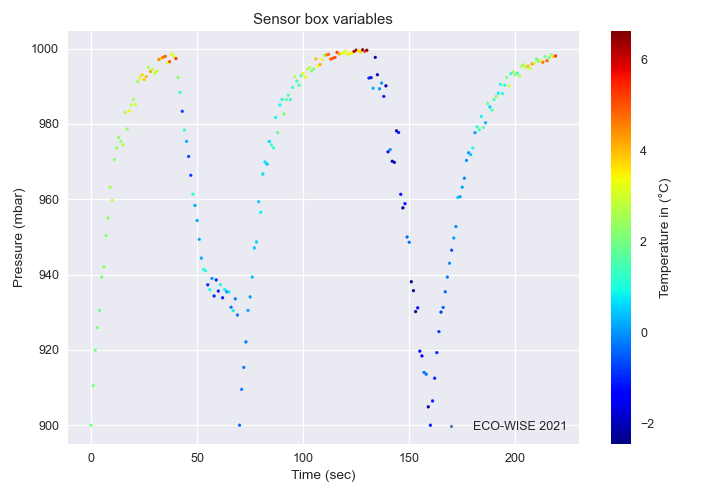

In [19]:
temp_in_plot = temp_press_in_plot(live_df.loc[:,['T_in','P_in','time']])

A live graph of the sensor box variables (Pressure and Temperature over Time) is a useful way of confirming that the sensors are operating smoothly. There is a predicted pattern of pressure over time knowing the sensor box’s different stages. (It should be mentioned that these presented measurements are the mean of two different sets of sensors placed in different locations inside the box to increase the validity and accuracy of the measurements)

In [28]:
def humidities(i):
    df = pd.read_csv('../Real-time analysis/Test scripts/data.csv', usecols=[0,5,6])
    
    hum_in.cla()
    hum_out.cla()
    
    hum_in.plot(df['time'], df['Hum_in'], label = "Hum in (ECO-WISE 2021)")
    hum_out.plot(df['time'], df['Hum_out'], label = "Hum out (ECO-WISE 2021)")
    
    hum_in.set_title("Humidity")
    hum_in.set_ylabel("Humidity Inside (%)")  
    hum_in.legend()
    
    hum_out.set_xlabel("Time (min)")
    hum_out.set_ylabel("Humidity Outside (%)")   
    hum_out.legend()

humidity_figure, (hum_in,hum_out) = plt.subplots(nrows=2, ncols=1, sharex=True)

ani = FuncAnimation(humidity_figure, humidities, interval=1000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


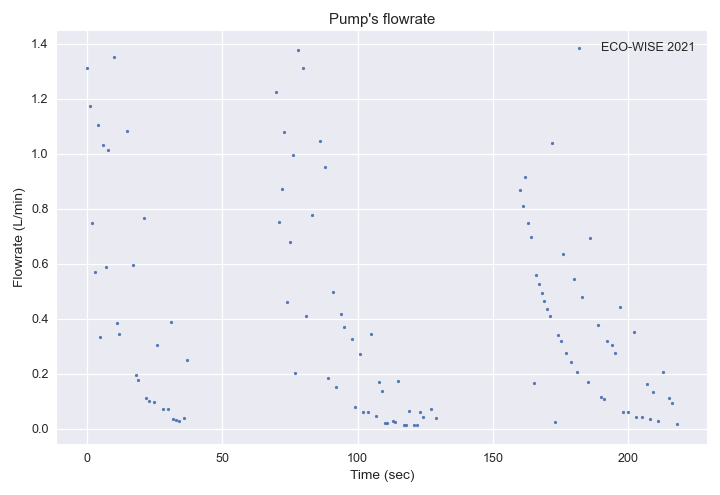

In [21]:
flow_plot = flow_rate_plot(live_df.loc[:,['time','Flowrate']])

In [29]:
def flowplot(i):
    df = pd.read_csv('../Real-time analysis/Test scripts/data.csv', usecols=[0,1,2,3,4,12])
    df['Flowrate'] = flowrate(df.mask(lambda x: x['flags']!=1))

    # print(df)
    ax1.cla()
    
    ax1.scatter(df['time'], df['Flowrate'], s=20, 
                marker= '.', label = "ECO-WISE 2021")
    
    ax1.set_title("Pump's flowrate")
    ax1.set_xlabel("Time (sec)")
    ax1.set_ylabel("Flowrate (L/min)")
    ax1.legend()

flow_rate_figure, ax1 = plt.subplots()

ani = FuncAnimation(flow_rate_figure, flowplot, interval=1000)

<IPython.core.display.Javascript object>

The pump flowrate is calculated using a theoretical model (Outside and inside temperature and pressure need to be measured) the validity of which has not been verified yet. During the process of calibrating the sensors a flowrate-meter will be used, and its measurements will be compared to the predicted values given by this model.

### Plots renewed using buttons

<IPython.core.display.Javascript object>


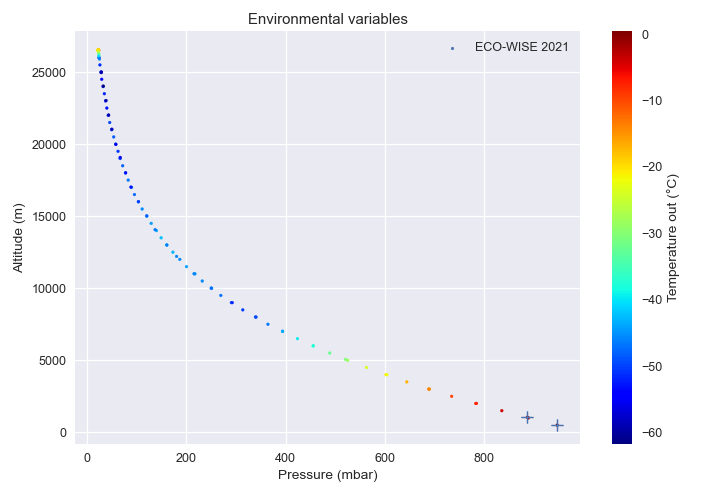

In [23]:
temp_out_plot = temp_press_out_plot(button_df.loc[:,['T_out','P_out','Altitude']])

Outside temperature and pressure over altitude are measured in order to calculate the flowrate of the air pump. Additionally, it was determined that graphing this data using a color bar to indicate temperature is an aesthetically pleasing and compact way to present some important information.

<IPython.core.display.Javascript object>


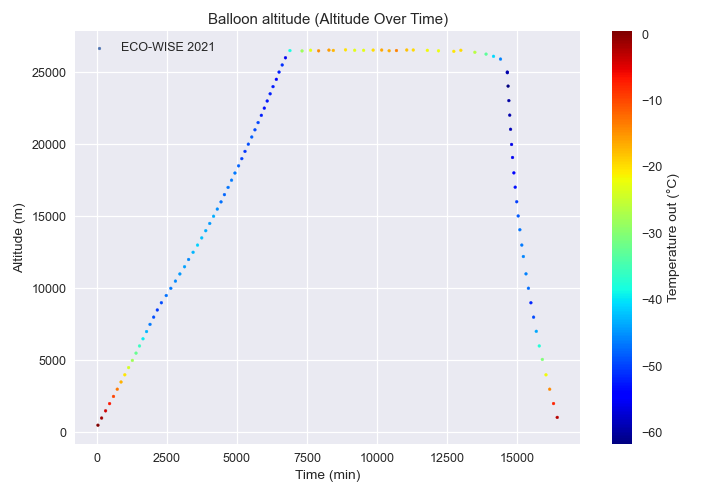

In [24]:
altitude_plot= altitude_time(button_df.loc[:,['time','Altitude','T_out']])

The Balloon’s Altitude is measured using both a GPS and an Altimeter. Due to the experiment’s requirements, the altimeter’s measurements are used (Increased accuracy. In fact, as with all other sensors, two altimeters are used). Again plotting the temperature on the graph is a compact way to add a third variable in a 2D graph.

<IPython.core.display.Javascript object>


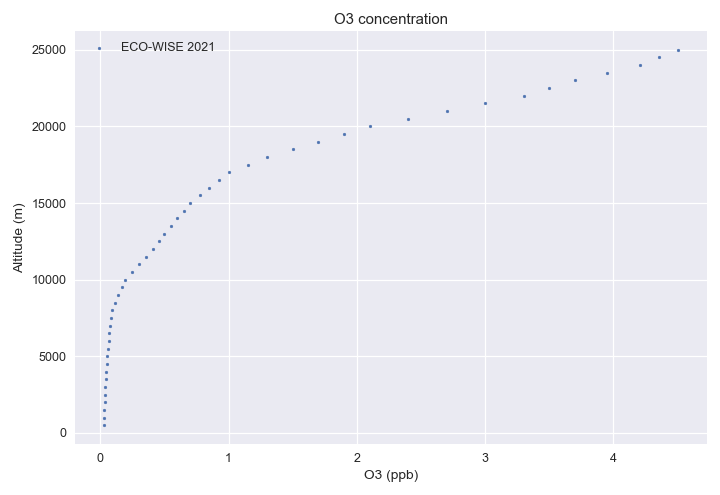

In [25]:
O3_plot = O3_conc(button_df.loc[:,['O3','Altitude']])

<IPython.core.display.Javascript object>


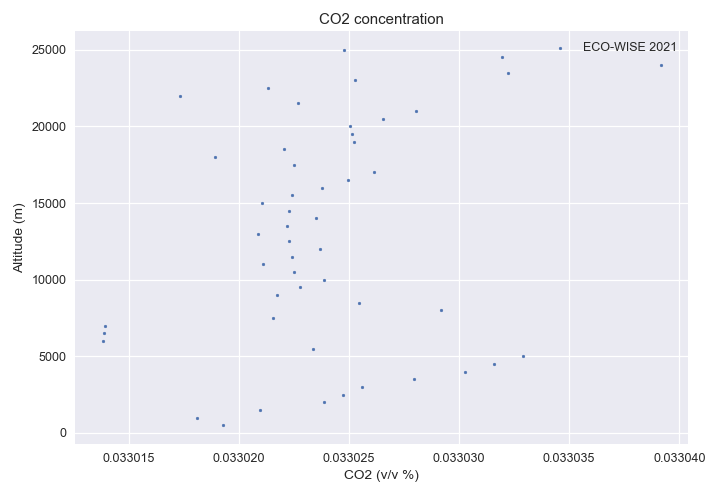

In [26]:
CO2_plot = CO2_conc(button_df.loc[:,['CO2','Altitude']])

The concentration of CO2 and Ο3 in the atmosphere (over altitude) is the primary target of this experiment so it is imperative that these calculated values are presented in a real-time graph 